In [45]:
import numpy as np
from scipy import stats
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
from scipy.optimize import curve_fit
from numba import jit

# Raport II - Proces Ryzyka i ułamkowy ruch Browna.
### Autorzy: Aleksandra Hodera (268733), Aleksandra Polak (268786)

## Spis treści:
1. Procedura wczytywania danych
2. Zadanie 1a) - *"proces Ryzyka"*
    - Wstęp
    - Dopasowanie rozkładu do danych
      - Wyjaśnienie, opis
      - Algorytm
      - Symulacja   
      - Podsumowanie, wnioski   
    - Jednorodny proces Poissona
      - Wyjaśnienie, opis
      - Algorytm
      - Symulacja
    - Estymacja parametrów procesu
      - Wyjaśnienie, opis    
      - Symulacja
      - Podsumowanie, wnioski  
    - Proces Ryzyka
      - Wyjaśnienie, opis
      - Algorytm
      - Symulacja      
      - Podsumowanie, wnioski 
3. Zadanie 1b) - *"prawdopodobieństwo ruiny"*
    - Wstęp
    - Moment ruiny - definicja
    - Prawdopodobieństwo ruiny w skończonym czasie
      - Wyjaśnienie, opis
      - Algorytm
      - Symulacja
    - Prawdopodobieństwo ruiny w nieskończonym czasie
      - Wyjaśnienie, opis
      - Wzór Pollaczka-Chinczyna
      - Aproksymacja $\Psi(u)$
        - Algorytm
      - Generowanie $Y_i$
        - Algorytm
      - Symulacja
    - Podsumowanie, wnioski     
4. Zadanie 1c) - *"ruina Paryska"*
    - Wyjaśnienie, opis
    - Algorytm
    - Symulacja
    - Podsumowanie, wnioski 
5. Zadanie 2a, b) - *"ułamkowy ruch Browna"*
    - Wyjaśnienie, opis
    - Ułamkowy ruch Browna
    - Ułamkowy szum gaussowski
    - Algorytm 
    - Symulacja
    - Funkcja $\mathbb{E}r^x$
      - Algorytm
      - Symulacja
    - Podsumowanie, wnioski 
6. Źródła 

## 1. Procedura wczytywania danych
Zanim przystąpimy do zadania musimy wczytać dane otrzymane od prowadzącego. W tym celu użyjemy biblioteki json. Następnie do odpowiednich zmiennych przypisujemy klucze słownika z naszymi danymi.

## 2. Zadanie 1a) 
### Wstęp
W poniższym zadaniu zajmiemy się klasycznym modelem procesu Ryzyka dla naszego zbioru danych. Zbiór ten zawiera trajektorie pewnego procesu wysymulowanego dla kroku czasowego $h = 0.05$ na odcinku $[0, 100]$ (horyzont czasowy: $T = 100$). Premia wynosi $\theta = 0.2$.


### Dopasowanie rozkładu do danych
#### Wyjaśnienie, opis
Zanim przejdziemy do dopasowania modelu Ryzyka musimy wyznaczyć rozkład zmiennej losowej $X_i$, gdzie $i$ to wielkość $i$-tej szkody z naszego zbioru.
W celu sprawdzenia poprawności wyznaczonego rozkładu porównaliśmy gęstość teoretyczną z histogramem, dystrybuanty teoretyczne i empiryczne oraz wykresy kwantylowe.
<br> Następnie wyliczymy średnią oraz wariancję z zestawu danych, korzystając z własności wyznaczonego rozkładu.

#### Algorytm
1. Tworzymy pustą listę.
2. Sprawdzamy czy kolejne punkty trajektorii spełniają nierówność:
$ y_{i} > y_{i+1} $.
3. Jeśli tak to do stworzonej listy dodajemy różnicę $y_{i} - y_{i+1} $.
4. Zwracamy listę z obliczonymi wartościami.
5. Wyliczamy wartość średnią oraz wariancję otrzymanych wartości.

####  Symulacja - pobieranie danych

In [46]:
f = open('zestaw1_2.json')
data = json.load(f)

In [47]:
T = data['T'] #horyzont
h = data['h'] #krok czasowy
theta = data['theta'] #wysokość premii
trajectory = data['trajektoria'] #pojedyncze trajektorie procesu ryzyka
u = trajectory[0]

####  Symulacja - znalezienie rozkładu $X_i$

In [48]:
@jit(nopython=True)
def find_x(data, T, h): # znalezienie wielkości i-tej szkody (rozkład x_i) i momentów skoków T_i
    result_x = []


    for i in range(1, len(data)): 
        if data[i - 1] > data[i]:
            result_x.append(data[i - 1] - data[i])
    
    return np.array(result_x)

In [49]:
X = find_x(trajectory, T, h)

c:\Users\Ola\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data' of function 'find_x'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_12112\2291853151.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Analizując wielkości konkretnych szkód stawiamy hipotezę, że nasze dane pochodzą z rozkładu jednostajnego $\mathrm{U}(a, b).$ Widzimy, że otrzymane wartości leżą w konkretnym przedziale (który wyznaczymy).
Korzystając z odpowiednich przekształceń wzorów na średnią i wariancję rozkładu jednostajnego, przedstawionych poniżej, wyznaczymy wzory na wartości parametrów $a$ i $b$ tego rozkładu, 
gdzie: $EX$ to średnia, a $VarX$ to wariancja z naszych danych.
<br> $ \begin{cases} EX = \frac{a + b}{2} \\ VarX = \frac{(b-a)^2}{12} \end{cases} $ $\iff$ $\begin{cases} 2 * EX = a + b \\ \sqrt{12 * VarX} = b-a \end{cases} $ 
<br> Odpowiednio dodając i odejmując stronami otrzymujemy:
$ \begin{cases}2a = 2 * EX - \sqrt{12 * VarX} \\ 2b = 2 * EX + \sqrt{12 * VarX} \end{cases} $ $\iff $ $ \begin{cases} a = EX - \sqrt{3 * VarX} \\ b = EX + \sqrt{3 * VarX} \end{cases} $


Następnie sprawdzimy czy nasz rozkład został poprawnie wyznaczony, porównując podstawowe charakterystyki rozkładu.


In [50]:
mi = np.mean(X) # średnia
Var = np.var(X) # wariancja
print("Wartość średnia oraz wariancja z próby: ", mi,",", Var)

Wartość średnia oraz wariancja z próby:  34.22676256740325 , 8.032140197560805


In [51]:
b = mi + np.sqrt(3*Var) #obliczenie parametrów rozkładu dzięki średniej i wariancji
a = mi - np.sqrt(3*Var)
t = np.arange(25, 45, h) 
print(a, b)


29.317952060500133 39.135573074306365


<!-- jak obliczamy a i b i dlaczego tak -->

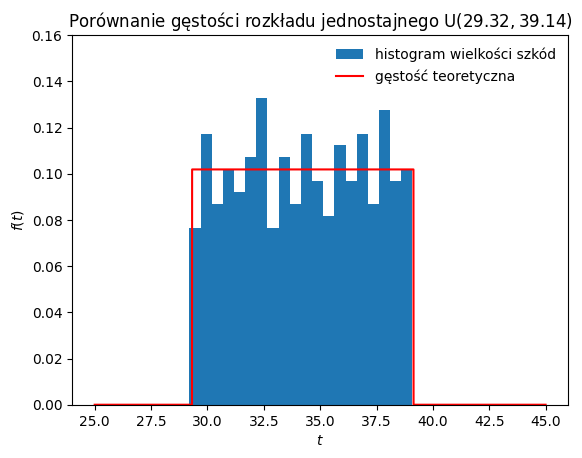

In [52]:
plt.hist(X, bins = 20, density=True, label = "histogram wielkości szkód")

f_theo = stats.uniform.pdf(t, a, b - a) # [loc, loc + scale]
plt.plot(t, f_theo, label = "gęstość teoretyczna", color = "red")

plt.title("Porównanie gęstości rozkładu jednostajnego $\mathrm{U} (29.32, 39.14)$")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.ylim(0, 0.16)
plt.legend(frameon=False)

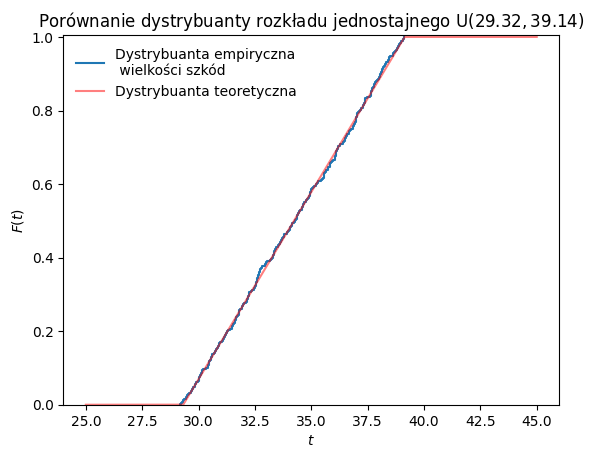

In [53]:
sb.ecdfplot(data = X, label = "Dystrybuanta empiryczna\n wielkości szkód")

th_F = stats.uniform.cdf(t, a, b - a) # [loc, loc + scale]
plt.plot(t, th_F, label = "Dystrybuanta teoretyczna", alpha = 0.5, color = "red")

plt.title("Porównanie dystrybuanty rozkładu jednostajnego $\mathrm{U} (29.32, 39.14)$")
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.ylim(0, 1.005)
plt.legend(frameon=False)

Text(0.5, 1.0, 'Wykres kwantylowy dla próbki względem rozkładu $\\mathrm{U} (29.32, 39.14)$')

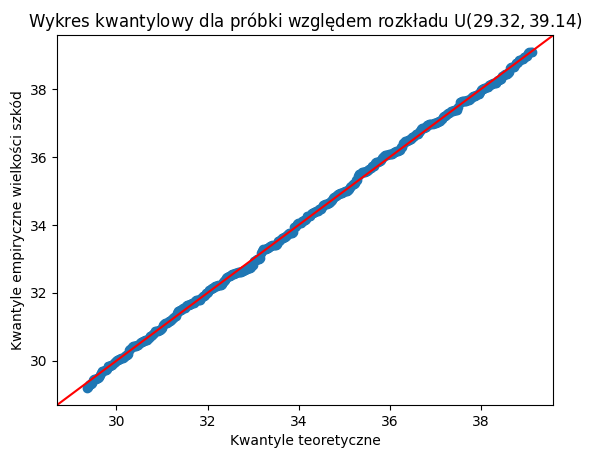

In [54]:
sm.qqplot(X, dist=stats.uniform(loc = a, scale = b - a), line = '45')
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne wielkości szkód")
plt.title("Wykres kwantylowy dla próbki względem rozkładu $\mathrm{U} (29.32, 39.14)$")

#### Podsumowanie, wnioski
Powyższe wykresy sugerują, że założona hipoteza jest prawdziwa. Oznacza to, że dane pochodzą najprawdopodobniej z rozkładu $\mathrm{U}(29.32, 39.14)$. Możemy również wnioskować, że nasza metoda estymacji parametrów rozkładu najprawdopodobniej jest prawidłowa.

### Jednorodny proces Poissona
#### Wyjaśnienie, opis
Jednorodnym procesem Poissona z intensywnością $\lambda > 0$ nazywamy proces liczący $N(t), t \geq 0$ spełniający:
1. $N(0) = 0.$
2. $N(t)$ ma niezależne przyrosty, to znaczy: $\forall _{0 \leq t_0 < t_1 < ... < t_n}$ zmienne losowe $N(t_1)-N(t_0), \ N(t_2)-N(t_1), \ ..., \ N(t_n)-N(t_{n-1})$ są niezależne.
3. $N(t)$ ma stacjonarne przyrosty, czyli $N(t) - N(s) \stackrel{d}{=} N(t-s).$
4. $N(t) \sim \mathrm{Poiss}(\lambda * t)$, czyli $P(N(t) = n) = e ^{-\lambda * t} * \frac{(\lambda * t)^n}{n!}.$
5. $N(t)$ mają trajektorie cadlag.

Jednorodnego procesu Poissona będziemy używać do symulowania trajektorii procesu Ryzyka.

#### Algorytm
Istnieją różna metody generowania niejednorodnego procesu Poissona. My użyliśmy metody generowania za pomocą czasów oczekiwania, której algorytm jest przedstawiony poniżej.
1. Ustalamy $t = 0$, $I = 0.$
2. Generujemy $U \sim \mathrm{U}(0, 1).$
3. Wstawiamy $t = t - \frac{1}{\lambda}\ln{U}.$
    Jeśli $ t>T$ STOP.
4. Wstawiamy $I = I + 1, S(I) = t.$
5. Wracamy do 2.

#### Symulacja
Poniżej została przedstawiona procedura symulacja jednorodnego procesu Poissona z parametrem intensywności $\lambda.$

In [55]:
@jit(nopython=True)
def poisson_process_1(lamb, T):
    I = 0
    t = 0
    S = []

    while True:
        U = np.random.uniform(0, 1)
        t -= (1/lamb)*np.log(U)

        if t > T:
            break

        else:
            I += 1
            S.append(t)
            
    return S

### Estymacja parametru procesu
#### Wyjaśnienie, opis    
Chcąc dopasować model Ryzyka potrzebujemy wyestymować także wartość parametru $\lambda > 0$, oznaczającego intensywność jednorodnego procesu Poissona. 
W tym celu wykorzystaliśmy funkcję opisującą premię: 
$$c(t) = \mu \lambda t (1 + \theta)$$
Przekształcając powyższy wzór, otrzymujemy:
$$ \lambda = \frac{c(t)}{\mu t (1 + \theta)} $$
Wiemy także, że przychód możemy zdefiniować jako różnicę dochodu i wszystkich poniesionych strat, czyli wartości, jaką mamy w horyzoncie czasowym $T$ (końcowa wartość) musimy odjąć kapitał posiadany na początku oraz poniesione straty (suma $i$-tych szkód).
Następnie, do wyznaczonego wzoru na $\lambda$, za $c(t)$ podstawiamy przychów, jako średnią przyjmujemy średnią z próby, a za $t$ podstawiamy horyzont czasowy $T$, czasowy $T$,



#### Symulacja

In [56]:
def est_lamb(X, u, T, theta, mi):
    losses = sum(X)
    lam = (trajectory[T] - u + losses)/((1+theta)*T*mi)
    return lam

lam = est_lamb(X, u, T, theta, mi)
print ("Wyestymowana wartość lambdy: ", lam)

Wyestymowana wartość lambdy:  3.303698807785659


Teraz narysujemy 100 trajektorii rozkładu Poissona z wyestymowaną intensywnością $\lambda \approx 3.303.$ W tym celu wykorzystamy algorytm generowania jednorodnego procesu Poissona oraz porównamy jego trajektorie z wartością średnią $E(N(t)) = \lambda t.$

In [57]:
S = [poisson_process_1(lam, T) for _ in range(100)]

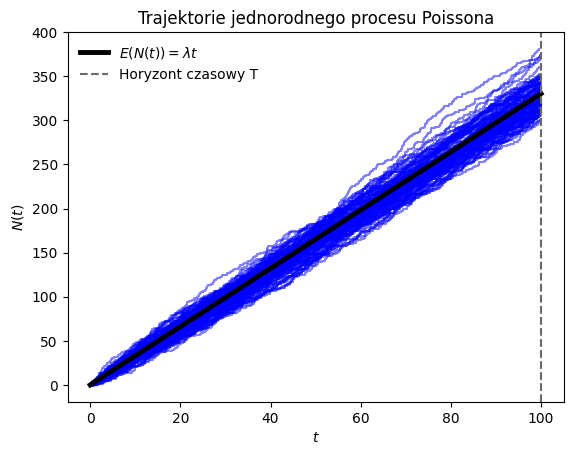

In [58]:
for el in S:
        plt.step(el, np.arange(len(el)), where = 'post', c = 'b', alpha = 0.5)

t = np.arange(0, T+h, h)
EN = lam*t
plt.plot(t, EN, c = 'black', linewidth = 3.5, label = "$E(N(t)) = \lambda t$")

plt.axvline(x = T, color = 'dimgrey', label = "Horyzont czasowy T", linestyle = "--")

plt.xlabel("$t$")
plt.ylabel("$N(t)$")
plt.title(f"Trajektorie jednorodnego procesu Poissona")
plt.legend(loc='best', frameon=False)

#### Podsumowanie, wnioski
Możemy zauważyć, że wartość wyestymowanego parametru $\lambda$ wynosi około 3.302. 

Widzimy także, że trajektorie procesu Poissona wygenerowanego na odcinku $[0, T]$ oscylują w pobliżu wartości średniej procesu.

### Proces Ryzyka
#### Wyjaśnienie, opis
Procesem Ryzyka nazywamy proces stochastyczny, który opisuje kapitał towarzystwa ubezpieczeniowego. Wyraża się on poniższym wzorem:
$$ R(t) \stackrel{def}{=} u + c(t) - \sum_{i=1}^{N(t)} X_i, $$
gdzie:
- $u > 0$ - kapitał początkowy,
- $c(t)$ - zazwyczaj funkcja deterministyczna oznaczająca premię (przychody ze sprzedaży polis),
- $N(t)$ - liczba szkód do momentu $t$, zliczanych przez jednorodny proces Poissona z intensywnością $\lambda$,
- $X_i$ - wysokość $i$-tego odszkodowania, $X_i$ - $iid$, $X_i \bot N(t)$, $EX_i = \mu < \infty$.

W naszym przypadku, gdy $N(t)$ pochodzą z procesu Poissona intensywnością $\lambda > 0$, funkcja opisująca premię ma postać:
$$ c(t) = \mu \lambda t (1 + \theta), $$
gdzie parametr $\theta > 0$ oznacza narzut.

#### Algorytm
1. Generuj jedną realizację $N(t)$ na $[0, T]$,
2. Generuj $X_1, ..., X_{N(T)}, \ X_i - iid$,
3. Wstaw $R(t) = u + c(t) - \sum_{i=1}^{N(t)} X_i $.

#### Symulacja
Po wyznaczeniu wszystkich parametrów potrzebnych do dopasowania modelu wysymulujemy trajektorie procesu Ryzyka. W tym celu skorzystamy z algorytmu widocznego powyżej. 

Dodatkowo, wygenerowaną wiązkę trajektorii porównaliśmy ze średnią wartością procesu Ryzyka:
$$ ER(t) = u + \theta \mu \lambda t.$$

Na wykresie przedstawiliśmy także jedną trajektorię procesu Ryzyka z pliku z danymi.

In [59]:
@jit(nopython=True)
def risk_process(a, b, u, lamb, T, mu, theta, t): 
    S = poisson_process_1(lamb, T)
    N = len(S)
    S = S + [T]
    X = np.random.uniform(a, b, size = N)
    R = []
    for i in range(len(t)):
        index = 0
        for j in range(1, len(S)):
            summ = 0
            if S[j-1] <= t[i] <= S[j]:
                index = j
                summ = np.sum(X[:index])
                break
        c = (1 + theta)*mu*lamb*t[i]
        R.append(u + c - summ)
    return R

In [60]:
t = np.arange(0, T+h, h)
R = [risk_process(a, b, u, lam, T, mi, theta, t) for _ in range(100)]

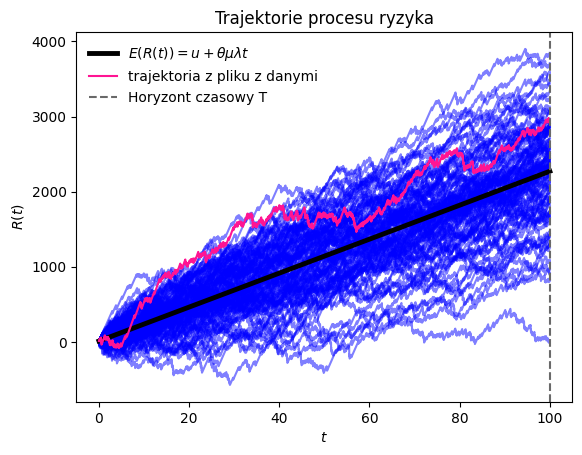

In [61]:
for el in R:
    plt.step(t, el, where = 'post', c = 'b', alpha = 0.5)
plt.xlabel("t")
plt.ylabel("R(t)")
plt.title("Proces ryzyka")

EN = u + theta*mi*lam*t
plt.plot(t, EN, c = 'black', linewidth = 3.5, label = "$E(R(t)) = u + \\theta \mu \lambda t$")

plt.step(t, trajectory, label = "trajektoria z pliku z danymi", c = 'deeppink')

plt.axvline(x = T, color = 'dimgrey', label = "Horyzont czasowy T", linestyle = "--")

plt.xlabel("$t$")
plt.ylabel("$R(t)$")
plt.title(f"Trajektorie procesu ryzyka")
plt.legend(loc='best', frameon=False)

#### Podsumowanie, wnioski  
Jak możemy zauważyć trajektoria z pliku z danymi wykazuje podobne zachowanie do trajektorii z wysymulowanych danych. Dodatkowo trajektorie te oscylują wokół wartości średniej procesu wyrażonej wzorem:
$$ ER(t) = u + \theta \mu \lambda t. $$ 
Pozwala nam wnioskować, że prawidłowo określiliśmy parametry rozkładu zmiennych $X_i$ będących wysokościami wypłacanych odszkodowań, oraz że sposób generowania trajektorii procesu Ryzyka również jest poprawny.


## 3. Zadanie 1b) 
### Wstęp
Celem tego zadania jest oszacowanie prawdopodobieństwa ruiny naszego procesu Ryzyka zarówno w skończonym, jak i nieskończonym czasie. 

### Moment ruiny - definicja
Moment ruiny oznacza najmniejszy moment czasowy, w którym proces ryzyka spada poniżej 0. Jest to zmienna losowa postaci:
$$ \tau(u) \stackrel{def}{=} \inf\{t \geq 0: R(t) < 0 \}.$$

### Prawdopodobieństwo ruiny w skończonym czasie
#### Wyjaśnienie, opis
W pierwszej kolejności zajmiemy się przypadkiem skończonego horyzontu czasowego $T$. Prawdopodobieństwo ruiny wyraża się wtedy wzorem:
$$ \Psi(u, T) \stackrel{def}{=} P(\tau(u) < T), $$
gdzie:
 - $\tau(u)$ - moment ruiny,
 - $T$ - horyzont czasowy.
Analizując wzór możemy zauważyć, że opisuje on prawdopodobieństwo tego, że bankructwo nastąpi przed czasem $T$.

Aby oszacować to prawdopodobieństw będziemy korzystać z symulacji metodą Monte Carlo. Polega ona na wielokrotnym sprawdzeniu ile, spośród wszystkich wygenerowanych trajektorii, spadło poniżej zera. Następnie dzielimy tę liczbę przez ilość kroków Monte Carlo.


#### Algorytm
1. Generuj $N$ trajektorii $R^{(1)}(t), \ ..., \ R^{(n)}(t)$ procesu Ryzyka na odcinku $[0, T]$,
2. Wyznacz liczbę trajektorii, które spadły poniżej zera,
3. Wstaw $\Psi(u, T) = \frac{n}{N}$, gdzie $n = \#\{i: inf_{t \in [0, T]} R^{(i)}(t) < 0 \}$

#### Symulacja

In [62]:
def ruin_finity_time(R):
    res = 0
    for el in R:
        if np.min(el) < 0:
            res += 1
    
    return res/len(R)

In [63]:
t = np.arange(0, T+h, h)
T = 100
R = [risk_process(a, b, u, lam, T, mi, theta, t) for _ in range(100)]

In [64]:
print("Prawdopodobieństwo ruiny dla horyzontu czasowego T = 100: ", ruin_finity_time(R))

Prawdopodobieństwo ruiny dla horyzontu czasowego T = 100:  0.77


In [65]:
T = 200
R = [risk_process(a, b, u, lam, T, mi, theta, t) for _ in range(100)]

In [66]:
print("Prawdopodobieństwo ruiny dla horyzontu czasowego T = 200: ", ruin_finity_time(R))

Prawdopodobieństwo ruiny dla horyzontu czasowego T = 200:  0.85


### Prawdopodobieństwo ruiny w nieskończonym czasie
#### Wyjaśnienie, opis
Następnie zajmiemy się oszacowaniem prawdopodobieństwa ruiny w nieskończonym czasie. Wyraża się ono wzorem:
$$ \Psi(u) \stackrel{def}{=} P(\tau(u) < \infty), $$
gdzie:
 - $\tau(u)$ - moment ruiny.

Niestety jawny wzór $\Psi(u)$ znany jest tylko w przypadku, gdy:
- $X_i$ mają rozkład wykładniczy,
- $X_i$ mają rozkład gamma,
- $X_i$ są mieszaniną rozkładów wykładniczych,
- $u = 0$.

Jednak dla klasycznego procesu Ryzyka możemy skorzystać ze wzoru Pollaczka-Chinczyna, który omówimy poniżej.

#### Wzór Pollaczka-Chinczyna
Prawdopodobieństwo ruiny w nieskończonym czasie opisuje wzór Pollaczka-Chinczyna, który ma następująca postać:
$$ \Psi(u) = \frac{\theta}{1 + \theta} * \sum_{n=0}^{\infty} \left(\frac{1}{1 + \theta}\right)^n * B_n(u), $$
gdzie:
- $B(u) \stackrel{def}{=} P(Y_1 + Y_2 + ... + Y_n > 0)$,
- $Y_i - iid$, o gęstości $f(x) = \frac{P(X_i > x)}{\mu}, x > 0$.


#### Aproksymacja $\Psi(u)$
Wykorzystamy także fakt, że:
<br> $\Psi(u) = P(Y_1 + ... + Y_K > u), Y_{i} \perp K $, gdzie: $ K \sim \mathrm{Geom}\left(\frac{\theta}{1 + \theta}\right)$. 

Czyli $P(K = i) = p (1-p)^n = \frac{\theta}{1 + \theta} \left(1 - \frac{\theta}{1 + \theta} \right)^i, i = 0, 1, ...$

#### Algorytm 
1. Wstaw I = 0.
2. Dla każdego $i = 1, ..., N$.
<br> * Generuj $k \sim \mathrm{Geom}\left(\frac{\theta}{(1 + \theta)}\right)$.
<br> * Generuj $ Y_1, ... Y_k$.
<br> * Jeśli $Y_1 + ... + Y_k > u$, to $I = I + 1$.
3. Wstaw $\Psi(u) = \frac{I}{N}$.

#### Generowanie $Y_i$
Zanim przystąpimy do generowania $Y_i$ z naszego rozkładu wyznaczymy jego dystrybuantę oraz gęstość, które następnie wykorzystamy do symulacji.

Wiemy, że zmienne $Y_i$ są $iid$, a ich gęstość wynosi $f(x) = \frac{P(X_i > x)}{\mu} = \frac{1 - P(X_i \leq x)}{\mu} = \frac{1 - F(x)}{\mu}, x > 0,$ $F(x)$ to dystrybuanta rozkładu jednostajnego.

Do obliczeń będziemy także potrzebować wartości średniej $X_i$, została ona także policzona numerycznie w zadaniu 1a) i wyniosła, w przybliżeniu 34.23. Porównamy tą wartość ze średnią rozkładu jednostajnego $\mathrm{U}(29.32, 39.14)$ (wartości zostały przybliżone do 2 miejsc po przecinku)
$$ \mu = EX_i \approx \frac{a + b}{2} = \frac{29.32 + 39.14}{2} = \frac{68.48}{2} = 34.24.$$
Jak widzimy średnie obliczone numerycznie i analitycznie są do siebie bardzo zbliżone, drobne różnice wynikają z zaokrągleń wartości.

Następnie zajmiemy się wyliczeniem dystrybuanty. Wiemy już, że dane pochodzą z rozkładu jednostajnego, którego dystrybuanta ma postać:
$F(x) = \begin{cases} 0, \ \ \ \ \ \ \ x<a \\ \frac{x-a}{b-a}, \ \ \ a \leq x < b \\ 1, \ \ \ \ \ \ \ x \geq b \end{cases}.$ Wiemy także, że $x > 0.$

Obliczając gęstość $Y_i$ otrzymujemy:

$f(x) = \begin{cases} \frac{1}{\mu}, \ \ \ \ \ \ \ \ \ 0<x<a \\ \frac{1}{\mu} \frac{b-x}{b-a}, \ \ \ a \leq x < b \\ 0, \ \ \ \ \ \ \ \ \ \ x \geq b \end{cases}.$ 

Wiemy również, że jest to funkcja ciągła, której $max$ wynosi $\frac{1}{\mu}.$

Znając gęstość zmiennych losowych $Y_i$ możemy przejść do ich generowania. W tym celu wykorzystamy metodę akceptacji - odrzucenia, z pomocniczym rozkładem jednostajnym. Metoda jej implementacji została umówiona na poprzednim raporcie.




#### Algorytm
1. Generuj $U_1 \sim \mathrm{U}(a = 29.32, b = 39.14), U_2 \sim \mathrm{U}(0, \frac{1}{\mu} = \frac{1}{34.23})$, $U_1 \perp U_2$
2. Jeśli $U_2 \leq f(U_1)$, zwróć $X = U_{1}$. 
<br> W przeciwnym wypadku wróć do 1.



#### Symulacja

In [67]:
T = 100

In [68]:
@jit(nopython=True)
def f(x, a, b, mi):
    if 0 <= x < a:
        return 1/mi

    elif a < x <= b:
        return (1/mi)*((b - x)/(b - a))

    else:
        return 0

@jit(nopython=True)
def generate_Y(N, a, b, mi):
    result = []
    n = 1/mi

    for _ in range(N):
        
        while True:
            U_1 = np.random.uniform(a, b)
            U_2 = np.random.uniform(0, n)
            
            if U_2 <= f(U_1, a , b, mi):
                result.append(U_1)
                break
                
    return result

def ruin_infinity_time(a, b, mi, theta, u):
    I = 0

    for _ in range(1000):
        k = 0
        p = theta/(1+theta)
        if np.random.rand() >= p:
            k += 1
        Y = generate_Y(k, a, b, mi)

        if np.sum(Y) > u:
            I += 1

    return I/1000
   

In [69]:
print("Prawdopodobieństwo ruiny w nieskończonym czasie wynosi: ", ruin_infinity_time(a, b, mi, theta, u))

Prawdopodobieństwo ruiny w nieskończonym czasie wynosi:  0.838


### Podsumowanie, wnioski  
Możemy zauważyć, że prawdopodobieństwo ruiny w skończonym czasie wynosi około $0.8.$ W przypadku nieskończonego czasu wartość ta jest zbliżona. Pozwala nam to wnioskować, że najbardziej istotnym odcinkiem dla tego procesu jest odcinek $[0, 100].$

## 4. Zadanie 1c) 
### Wyjaśnienie, opis
W tym zadaniu zajmiemy się modelem "ruiny paryskiej". Określenie to odnosi się do sytuacji, podczas której kapitał firmy znajduje się przez $q$ kolejnych jednostek czasu poniżej poziomu 0. Dopiero po przekroczeniu tego czasu nastąpi bankructwo. 

### Algorytm
1. Stwórz pustą listę.
2. Generuj $N$ trajektorii $R^{(1)}(t), \ ..., \ R^{(n)}(t)$ procesu Ryzyka na odcinku $[0, T]$,
3. Sprawdź czy $inf_{t \in [0, T]} R^{(i)}(t) < 0 $
4. Sprawdź dla jakiej wartości $n$ został spełniony warunek z 2) i czy wartość ta jest $\geq q$.
5. Wyznacz liczbę trajektorii, dla których powyższe warunki są spełnione, a następnie podziel ją przez liczbę wszystkich trajektorii.
6. Zwróć listę z obliczonymi wartościami.


### Symulacja
W poniższej symulacji spróbujemy określić zależność zmiany prawdopodobieństwa ruiny od wartości $q.$

Następnie sprawdzimy jak zmienia się prawdopodobieństwo ruiny w zależności od kapitału początkowego $u.$ oraz przyjętej wartości $q$.

Spróbujemy także odpowiedzieć na pytanie jak zmienia się średni czas osiągnięcia ruiny w zależności od czasu.


- Zależność prawdopodobieństwa ruiny od $q.$

In [70]:
def ruin_paris(a, b, u, lam, T, mi, theta, t, qs):
    result = []
    for q in qs:
        pr = 0
        for i in range(100):
            R = risk_process(a, b, u, lam, T, mi, theta, t)
            if np.min(R) < 0 and R.index(np.min(R)) >= q:
                pr += 1
        result.append(pr/100)
    return result

In [71]:
q_values = [1, 15, 55, 100, 250, 350, 500, 600, 800, 1000, 1200, 1300, 1400, 1500, 1600, 1800, 2000] 

In [72]:
T = 100
results = ruin_paris(a, b, u, lam, T, mi, theta, t, q_values)

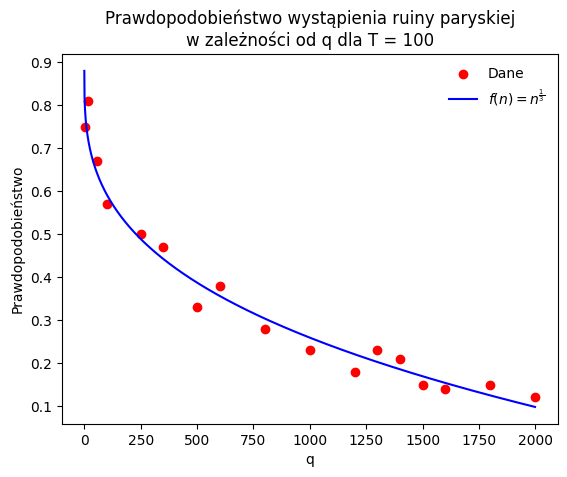

In [73]:
plt.scatter(q_values, results, label="Dane", c='r')

def func(x, a, b): 
    return a*np.array(x)**(1/3) + b

popt, pcov = curve_fit(func, q_values, results) 
x = np.arange(2000)
plt.plot(x,func(x,*popt),c = "blue", label = '$f(n) = n^{\\frac{1}{3}}$')

plt.xlabel("q")
plt.ylabel("Prawdopodobieństwo")
plt.title(f"Prawdopodobieństwo wystąpienia ruiny paryskiej\nw zależności od q dla T = 100")
plt.legend(loc='best', frameon=False)

In [74]:
T = 200
results_ = ruin_paris(a, b, u, lam, T, mi, theta, t, q_values)

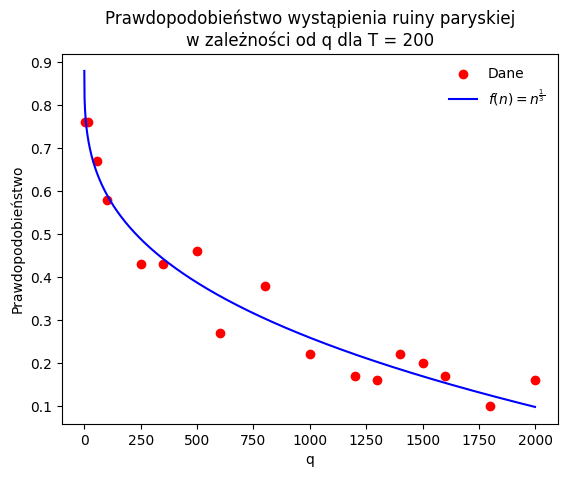

In [75]:
plt.scatter(q_values, results_, label="Dane", c='r')

def func(x, a, b): 
    return a*np.array(x)**(1/3) + b

popt, pcov = curve_fit(func, q_values, results) 
x = np.arange(2000)
plt.plot(x,func(x,*popt),c = "blue", label = '$f(n) = n^{\\frac{1}{3}}$')

plt.xlabel("q")
plt.ylabel("Prawdopodobieństwo")
plt.title(f"Prawdopodobieństwo wystąpienia ruiny paryskiej\nw zależności od q dla T = 200")
plt.legend(loc='best', frameon=False)

- Prawdopodobieństwo ruiny w zależności od kapitału początkowego i przyjętej wartości $q.$

In [88]:
def ruin_paris(a, b, us, lam, T, mi, theta, t, qs):
    result = []
    for u in us:
        pr = 0
        for i in range(100):
            R = risk_process(a, b, u, lam, T, mi, theta, t)
            if np.min(R) < 0 and R.index(np.min(R)) >= qs:
                pr += 1
        result.append(pr/100)
    return result

In [89]:
T = 100
us = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = [ruin_paris(a, b, us, lam, T, mi, theta, t, q) for q in (10,40,100)]

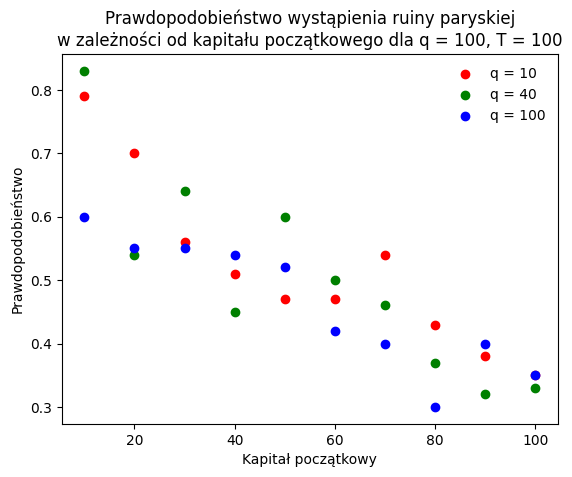

In [91]:
plt.scatter(us, results[0], label="q = 10", c='r')
plt.scatter(us, results[1], label="q = 40", c='g')
plt.scatter(us, results[2], label="q = 100", c='b')

plt.xlabel("Kapitał początkowy")
plt.ylabel("Prawdopodobieństwo")
plt.title(f"Prawdopodobieństwo wystąpienia ruiny paryskiej\nw zależności od kapitału początkowego dla q = 100, T = 100")
plt.legend(loc='best', frameon=False)

### Podsumowanie, wnioski  
Możemy zauważyć, że niezależnie od wartości $T$, czym większe q, tym mniejsze prawdopodobieństwo ruiny. Jest to zgodne z naszymi przypuszczeniami. 
Widzimy także, że zależność ta dąży do 0 potęgowo.

W kolejnej części widzimy, że czym większy kapitał początkowy, tym mniejsze prawdopodobieństwo ruiny. Taka zależność występuje niezależnie od przyjętej wartości $q.$

Analizując wszystkie powyższe wykresy stworzone na odcinku $[0, T]$ możemy wywnioskować, że czym większa wartość $q$ tym mniejsze prawdopodobieństwo ruiny. Co za tym, będziemy musieli dłużej na nią czekać.

## 6. Źródła
<br> [1] Sheldon M. Ross "Simulation".
<br> [2] https://linuxhint.com/use-latex-jupyter-notebook/
<br> [3] https://pl.wikibooks.org/wiki/LaTeX/Matematyka
<br> [4] https://www.researchgate.net/publication/
<br> [5] 257342701_Porownanie_prawdopodobienstw_paryskiej_i_klasycznej_ruiny_dla_procesu_ryzyka_typu_Levy'ego
<br> [6] https://www.wmi.uni.wroc.pl/sites/default/files/upload_attach/Kepczynski.pdf
<br> [7] Wiedza oraz notatki z wykładów z przedmiotu "Symulacje komputerowe" i "Modelowanie stochastyczne" prowadzonych przez prof. dr hab. inż. Marcina Magdziarza oraz laboratoriów z przedmiotu "Symulacje komputerowe" prowadzonych przez dr inż. Mateusza Świtałę.

